In [1]:
# Useful starting lines
%matplotlib inline

import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
from tqdm import tqdm
%load_ext autoreload
%autoreload 2

## Load the Data
Note that `ratings` is a sparse matrix that in the shape of (num_items, num_users)

In [2]:
from helpers import load_data, preprocess_data

path_dataset = "movielens100k.csv"
ratings = load_data(path_dataset)

number of items: 1682, number of users: 943


### Plot the number of ratings per movie and user

In [3]:
ratings.shape

(1682, 943)

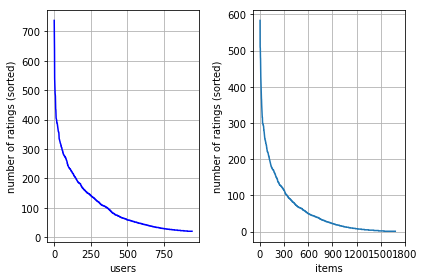

min # of items per user = 20, min # of users per item = 1.


In [4]:
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

### Split the data into a train and test set

In [5]:
def split_data(ratings, num_items_per_user, num_users_per_item,
               min_num_ratings, p_test=0.1):
    """split the ratings to training data and test data.
    Args:
        min_num_ratings: 
            all users and items we keep must have at least min_num_ratings per user and per item. 
    """
    # set seed
    np.random.seed(988)
    
    # select user and item based on the condition.
    valid_users = np.where(num_items_per_user >= min_num_ratings)[0]
    valid_items = np.where(num_users_per_item >= min_num_ratings)[0]
    valid_ratings = ratings[valid_items, :][: , valid_users]  
    
    # just cut the matrix by movies
    #items_to_test  = np.random.choice(range(valid_ratings.shape[0]), int(valid_ratings.shape[0] * p_test))
    #items_to_train = np.setdiff1d(range(valid_ratings.shape[0]), items_to_test)
    
    #test  = valid_ratings[items_to_test, :]
    #train = valid_ratings[items_to_train, :]
    
    nnz = valid_ratings.nnz
    
    items_to_test  = np.random.choice(range(nnz), int(nnz * p_test))
    items_to_train = np.setdiff1d(range(nnz), items_to_test)
    
    test = valid_ratings.copy()
    test[tuple(valid_ratings.nonzero()[i][items_to_train] for i in range(2))] = 0
    
    train = valid_ratings - test
    
    print("Total number of nonzero elements in origial data:{v}".format(v=ratings.nnz))
    print("Total number of nonzero elements in train data:{v}".format(v=train.nnz))
    print("Total number of nonzero elements in test data:{v}".format(v=test.nnz))
    return valid_ratings, train, test

Total number of nonzero elements in origial data:99999
Total number of nonzero elements in train data:88613
Total number of nonzero elements in test data:9339


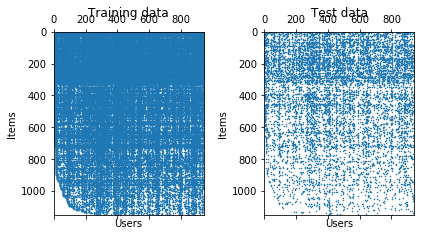

In [6]:
from plots import plot_train_test_data

valid_ratings, train, test = split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=10, p_test=0.1)
plot_train_test_data(train, test)

### Use the global mean to do the prediction

In [92]:
from helpers import calculate_mse

def baseline_global_mean(train, test):
    """baseline method: use the global mean."""
    
    x, y, z = scipy.sparse.find(train)
    prediction = np.mean(z)
    
    mse = calculate_mse(scipy.sparse.find(test)[2], prediction) / len(test.nonzero()[0]) / 2
    
    print("MSE: %f" % mse)
    
baseline_global_mean(train, test)

MSE: 0.607483


### Use the user means as the prediction

In [93]:
def baseline_user_mean(train, test):
    """baseline method: use the user means as the prediction."""
    mse = 0
    num_items, num_users = train.shape
    
    x, y, z = scipy.sparse.find(train)
    
    countings = np.bincount(y)
    sums      = np.bincount(y, weights=z)
    averages  = sums / countings
    
    # test users for nonzero entries
    test_users = scipy.sparse.find(test)[1]
    
    mse = calculate_mse(scipy.sparse.find(test)[2], averages[test_users]) / len(test.nonzero()[0]) / 2
    print("MSE: %f" % mse)

baseline_user_mean(train, test)

MSE: 0.519399


### Use the item means as the prediction

In [95]:
def baseline_item_mean(train, test):
    """baseline method: use item means as the prediction."""
    mse = 0
    num_items, num_users = train.shape
    
    x, y, z = scipy.sparse.find(train)
    
    countings = np.bincount(x)
    sums      = np.bincount(x, weights=z)
    averages  = sums / countings
    
    # test items for nonzero entries
    test_items = scipy.sparse.find(test)[0]
    
    mse = calculate_mse(scipy.sparse.find(test)[2], averages[test_items]) / len(test.nonzero()[0]) / 2
    print("MSE: %f" % mse)
    
baseline_item_mean(train, test)

MSE: 0.508059


### Learn the Matrix Factorization using SGD

#### Initialize matrix factorization

In [96]:
def init_MF(train, num_features):
    """init the parameter for matrix factorization."""
    
    num_items, num_users = train.shape
    
    x, y, z = scipy.sparse.find(train)
    averages  = np.bincount(x, weights=z) / np.bincount(x)
    
    # test items for nonzero entries
    #test_items = scipy.sparse.find(test)[0]
    
    #mse = calculate_mse(scipy.sparse.find(test)[2], averages[test_items]) / len(test.nonzero()[0]) / 2
    #print("MSE: %f" % mse)
    
    #     user_features: shape = num_features, num_user
    user_features = np.random.randn(num_features, num_users) / 100
    #user_features = np.zeros((num_features, num_users))
    user_features[0, :] = 1
    
    #     item_features: shape = num_features, num_item
    item_features = np.random.randn(num_features, num_items) / 100
    #item_features = np.zeros((num_features, num_items))
    item_features[0, :] = averages
    
    
    return user_features, item_features

Compute the cost by the method of matrix factorization.


In [97]:
def compute_error(data, user_features, item_features, nz):
    """compute the loss (MSE) of the prediction of nonzero elements."""
    # calculate rmse (we only consider nonzero entries.)
    
    res = 0
    
    for nz_row, nz_col in nz:
        res += np.mean((data[nz_row, nz_col] - np.dot(item_features[:, nz_row], user_features[:, nz_col])) ** 2)
        
    res /= len(nz) * 2
    
    return res

RMSE on test set: 0.5080663945225956
iter: 0, RMSE on training set: 0, on test set: 0.5781871172955984, norms: 35.19857381482573, 104.06663819171033
iter: 1, RMSE on training set: 0, on test set: 0.5351383336129983, norms: 37.569119451353444, 98.00637613837097
iter: 2, RMSE on training set: 0, on test set: 0.5190845375660303, norms: 39.23709563293248, 93.75213046862446
iter: 3, RMSE on training set: 0, on test set: 0.4778046865651056, norms: 41.54678713535449, 91.26299609143766
iter: 4, RMSE on training set: 0, on test set: 0.4574332811515221, norms: 44.453021706374166, 90.21476993003722
iter: 5, RMSE on training set: 0, on test set: 0.44297656251794476, norms: 47.022072138764635, 89.81621495308892
iter: 6, RMSE on training set: 0, on test set: 0.43139680614470294, norms: 49.743503257911215, 90.08648884737005
iter: 7, RMSE on training set: 0, on test set: 0.43788929306030294, norms: 52.120554506712736, 90.56468280976502
iter: 8, RMSE on training set: 0, on test set: 0.44032213383727814

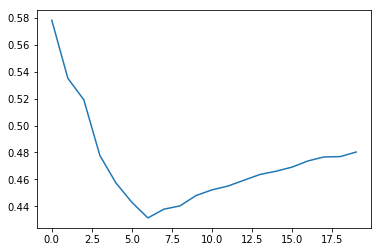

In [98]:
def matrix_factorization_SGD(train, test, gamma = 0.05, num_epochs = 5, lambda_ = 1e-3):
    """matrix factorization by SGD."""
    # define parameters
    num_features = 20   # K in the lecture notes
    lambda_user = lambda_
    lambda_item = lambda_
    errors = []
    
    # set seed
    np.random.seed(988)

    # init matrix
    user_features, item_features = init_MF(train, num_features)
    
    # find the non-zero ratings indices 
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))
    nz_row, nz_col = test.nonzero()
    nz_test = list(zip(nz_row, nz_col))
    
    rmse_test = compute_error(test,  user_features, item_features, nz_test)
    print("RMSE on test set: {}".format(rmse_test))

    for it in range(num_epochs):        
        # shuffle the training rating indices
        np.random.shuffle(nz_train)
        
        # decrease step size
        gamma /= 1.1
        
        for d, n in nz_train:
            f_item, f_user = np.copy(item_features[:, d]), np.copy(user_features[:, n])
            delta = -(train[d, n] - np.dot(f_item, f_user))

            user_delta, item_delta = delta * f_item, delta * f_user
            item_features[:, d] -= gamma * (item_delta + train.shape[0] * f_item * lambda_item)
            user_features[:, n] -= gamma * (user_delta + train.shape[1] * f_user * lambda_user)

        #rmse      = compute_error(train, user_features, item_features, nz_train)
        rmse_test = compute_error(test,  user_features, item_features, nz_test)
            
        print("iter: {}, RMSE on training set: {}, on test set: {}, norms: {}, {}".format(it, 0, rmse_test,
                                                                                         np.linalg.norm(user_features),
                                                                                         np.linalg.norm(item_features)))
        
        errors.append(rmse_test)
        
    plt.plot(errors)
    
    return user_features, item_features


us_f, it_f = matrix_factorization_SGD(train, test, num_epochs = 20, gamma = 0.01, lambda_ = 1e-10)

### Learn the Matrix Factorization using Alternating Least Squares

In [ ]:
def update_user_feature(
        train, item_features, lambda_user,
        nnz_items_per_user, nz_user_itemindices):
    """update user feature matrix."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # update and return user feature.
    # ***************************************************
    raise NotImplementedError

def update_item_feature(
        train, user_features, lambda_item,
        nnz_users_per_item, nz_item_userindices):
    """update item feature matrix."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # update and return item feature.
    # ***************************************************
    raise NotImplementedError

In [14]:
from helpers import build_index_groups


def ALS(train, test):
    """Alternating Least Squares (ALS) algorithm."""
    # define parameters
    num_features = 20   # K in the lecture notes
    lambda_user = 0.1
    lambda_item = 0.7
    stop_criterion = 1e-4
    change = 1
    error_list = [0, 0]
    
    # set seed
    np.random.seed(988)

    # init ALS
    user_features, item_features = init_MF(train, num_features)
    
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # start you ALS-WR algorithm.
    # ***************************************************
    raise NotImplementedError

ALS(train, test)

NotImplementedError: 